# Predict number of bookings

## Data Pre-processing

In [ ]:
from sqlite3 import connect
import pandas as pd
from pandas import read_sql_query

conn = connect("db.sqlite")
query = """
SELECT date, location, event_attendance
FROM events
"""
events = read_sql_query(query, conn)
conn.close()

events.to_csv("events.csv", index=False)
print(events.head())
df = pd.read_csv("events.csv")

                  date        location  event_attendance
0  2022-01-01 00:00:00      East Coker               707
1  2022-01-01 00:00:00  Little Gidding               761
2  2022-01-08 00:00:00      East Coker               563
3  2022-01-08 00:00:00  Little Gidding              1186
4  2022-01-10 00:00:00  Little Gidding              1765


In [ ]:
#data formatting
df['date'] = pd.to_datetime(df['date']) 
df['date'] = df['date'].dt.date

#check for unique locations
print(df['location'].unique())

#seperate dataframes for unique locations
df_ec = df[df['location'] == 'East Coker'][['date', 'event_attendance']].copy().reset_index(drop=True)
df_lg = df[df['location'] == 'Little Gidding'][['date', 'event_attendance']].copy().reset_index(drop=True)

print("ec:")
print(df_ec.tail())

print("lg:")
print(df_lg.tail())


['East Coker' 'Little Gidding']
ec:
           date  event_attendance
165  2025-03-01               544
166  2025-03-08               875
167  2025-03-15               871
168  2025-03-22               705
169  2025-03-29               634
lg:
          date  event_attendance
75  2025-02-26              1635
76  2025-02-28              1965
77  2025-03-15              1277
78  2025-03-22               905
79  2025-03-30              1510


#### Prompts used:
- remove 00:00:00 from date

### Fit into model(prophet)

In [ ]:
from prophet import Prophet

# Rename columns to fit Prophet's expected format
df_ec.rename(columns={'date': 'ds', 'event_attendance': 'y'}, inplace=True)
df_lg.rename(columns={'date': 'ds', 'event_attendance': 'y'}, inplace=True)

# Initialize Prophet models
model_ec = Prophet()
model_lg = Prophet()

# Fit the models
model_ec.fit(df_ec)
model_lg.fit(df_lg)

22:13:06 - cmdstanpy - INFO - Chain [1] start processing
22:13:06 - cmdstanpy - INFO - Chain [1] done processing
22:13:06 - cmdstanpy - INFO - Chain [1] start processing
22:13:06 - cmdstanpy - INFO - Chain [1] done processing


#### Prompts
- How to fit dataframe into prophet

### Predicts attendance for days in Jan-Mar, 2025

In [10]:
#generate dataframes for every day in Jan–Mar 2025
future_ec = pd.date_range(start='2025-01-01', end='2025-03-31', freq='D').to_frame(index=False, name='ds')
future_lg = pd.date_range(start='2025-01-01', end='2025-03-31', freq='D').to_frame(index=False, name='ds')

#predict attendance for Jan–Mar 2025
forecast_ec = model_ec.predict(future_ec)
forecast_lg = model_lg.predict(future_lg)

#rename columns for final output
forecast_ec_final = forecast_ec[['ds', 'yhat']].rename(columns={'ds': 'date', 'yhat': 'predicted_attendance'})
forecast_lg_final = forecast_lg[['ds', 'yhat']].rename(columns={'ds': 'date', 'yhat': 'predicted_attendance'})

# Round predicted attendance to nearest integer
forecast_ec_final['predicted_attendance'] = forecast_ec_final['predicted_attendance'].round().astype(int)
forecast_lg_final['predicted_attendance'] = forecast_lg_final['predicted_attendance'].round().astype(int)

# Save the final forecasts to CSV files
forecast_ec_final.to_csv("east_coker_forecast.csv", index=False)
forecast_lg_final.to_csv("little_gidding_forecast.csv", index=False)

#### Prompts
- use prophet to make predictions of attendance on my dataframe, from Jan 2025 to March 2025
- round the number of attendance

### Visualizing data to spot trends

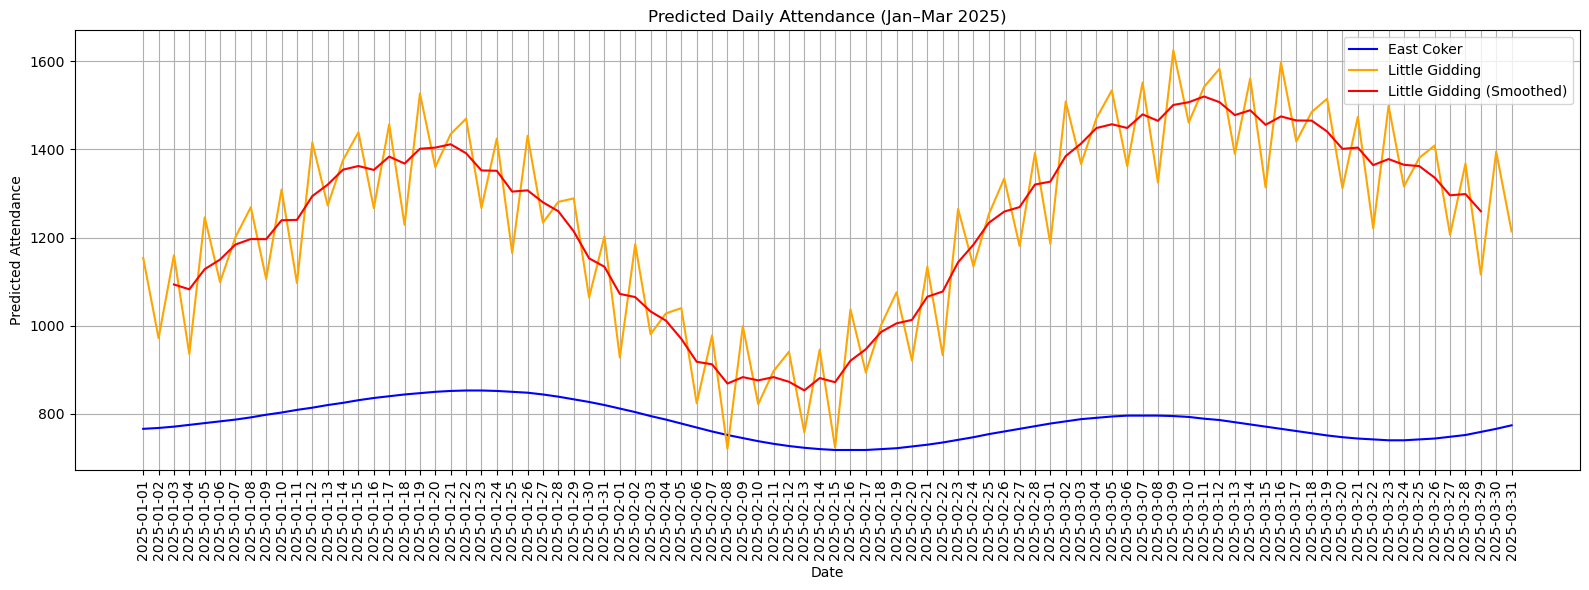

In [ ]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(16, 6))
plt.plot(forecast_ec_final['date'], forecast_ec_final['predicted_attendance'], label='East Coker', color='blue')
plt.plot(forecast_lg_final['date'], forecast_lg_final['predicted_attendance'], label='Little Gidding', color='orange')

forecast_lg_final['smoothed_attendance'] = forecast_lg_final['predicted_attendance'].rolling(window=5, center=True).mean()
plt.plot(forecast_lg_final['date'], forecast_lg_final['smoothed_attendance'], label='Little Gidding (Smoothed)', color='red')

# Formatting
plt.title('Predicted Daily Attendance (Jan–Mar 2025)')
plt.xlabel('Date')
plt.ylabel('Predicted Attendance')

# Set all x-ticks to the actual date values
plt.xticks(
    ticks=forecast_ec_final['date'], 
    labels=forecast_ec_final['date'].dt.strftime('%Y-%m-%d'),  # Format dates as 'YYYY-MM-DD'
    rotation=90
)

plt.grid(True)
plt.legend()
plt.tight_layout()

# Show plot
plt.show()

#### Prompts
- use matplotlib to plot my data
- label each data points with date
- my graph is spikey, how to smoothen it?

#### Visual justification of spikes for Little Gidding
The sharp spikes in the plot may indicate the presence of outliers, or they might genuinely reflect real fluctuations due to fine-grained data sampling. The jagged nature of the curve suggests significant variability at a detailed level.


### Proceeding to Validate My Suspicion That Little Gidding Contains Outlier

In [ ]:
from prophet.diagnostics import cross_validation, performance_metrics

# Cross-validation for EC (169 points)
df_cv_ec = cross_validation(
     model_ec,
     initial='365 days',     # training window
     period='90 days',       # spacing between folds
     horizon='90 days'       # forecast length
 )

# Cross-validation for LG (79 points)
df_cv_lg = cross_validation(
    model_lg,
    initial='365 days',      # training window
    period='30 days',       # spacing between folds
    horizon='90 days'       # forecast length
)

# Evaluate performance
df_perf_ec = performance_metrics(df_cv_ec)
df_perf_lg = performance_metrics(df_cv_lg)


print("Performance for EC:")
print(df_perf_ec)

print("\nPerformance for LG:")
print(df_perf_lg)

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/9 [00:00<?, ?it/s]22:21:45 - cmdstanpy - INFO - Chain [1] start processing
22:21:45 - cmdstanpy - INFO - Chain [1] done processing
 11%|█         | 1/9 [00:00<00:01,  5.59it/s]22:21:45 - cmdstanpy - INFO - Chain [1] start processing
22:21:45 - cmdstanpy - INFO - Chain [1] done processing
 22%|██▏       | 2/9 [00:00<00:01,  4.72it/s]22:21:45 - cmdstanpy - INFO - Chain [1] start processing
22:21:45 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 3/9 [00:00<00:01,  4.55it/s]22:21:45 - cmdstanpy - INFO - Chain [1] start processing
22:21:46 - cmdstanpy - INFO - Chain [1] done processing
 44%|████▍     | 4/9 [00:00<00:01,  4.01it/s]22:21:46 - cmdstanpy - INFO - Chain [1] start processing
22:21:46 - cmdstanpy - INFO - Chain [1] done processing
 56%|█████▌    | 5/9 [00:01<00:00,  4.92it/s]22:21:46 - cmdstanpy - INFO - Chain [1] start processing
22:21:46 - c

Performance for EC:
   horizon           mse        rmse         mae      mape     mdape  \
0   9 days  20084.041872  141.718178  114.260005  0.166588  0.148319   
1  10 days  17417.007028  131.973509  104.553750  0.153819  0.115562   
2  11 days  18334.168621  135.403725  110.582730  0.160442  0.128648   
3  12 days  26442.985209  162.612992  133.606249  0.185383  0.148319   
4  13 days  27253.448548  165.086185  131.658556  0.177993  0.128648   
..     ...           ...         ...         ...       ...       ...   
77 86 days  33975.645082  184.324836  164.499107  0.218505  0.185485   
78 87 days  26830.755360  163.800963  144.501589  0.196032  0.178849   
79 88 days  24212.183182  155.602645  130.867201  0.181690  0.166229   
80 89 days  28500.417711  168.820667  137.134278  0.191344  0.166229   
81 90 days  30669.324429  175.126595  144.307222  0.202937  0.215385   

       smape  coverage  
0   0.161617  0.727273  
1   0.146474  0.818182  
2   0.153756  0.818182  
3   0.184279  0

#### Prompts
- for prophet, how to measure the validity of the model's output
- use cross-validation
- what does initial, period and horizon mean?
- How do I interpret the output? Can it reveal outliers?

#### Quantitative justification of spikes for Little Gidding:

From the performance metrics, we observe that the RMSE for Little Gidding is significantly higher than its MAE. Given that MAE is more robust to outliers than RMSE, this large difference suggests the presence of outliers within the dataset.
In contrast, the difference between RMSE and MAE for East Coker is minimal, indicating a more consistent error distribution and a lower likelihood of outliers.

## Findings

The predicted attendance from January to March 2025 reveals distinct patterns for East Coker and Little Gidding. East Coker shows a smooth, steady trend with peaks in late January and early March, and a trough in mid-February. This reflects a stable visitor flow, likely driven by mild seasonal interest and occasional tourism tied to its historical and literary value as T. S. Eliot’s burial place.

In contrast, Little Gidding shows sharp fluctuations, with peaks around January 20 and March 11, and a trough mid-February. These spikes may result from one-off events like pilgrimages or group tours, which are common due to its religious and literary heritage. A significant gap between RMSE and MAE confirms the presence of outliers. After smoothing, the curve aligns more with East Coker’s trend, suggesting that the original volatility may be due to irregular bulk bookings or noise
